<div class="alert alert-info">
**Note:**

You can download this demo as a Jupyter notebook [here](https://github.com/ejhigson/nestcheck/blob/master/docs/demos/quickstart_demo.ipynb) and run it interactively yourself. The PolyChord nested sampling run data it uses can be downloaded at [https://github.com/ejhigson/nestcheck_demo_data](https://github.com/ejhigson/nestcheck_demo_data) (this also contains runs using a few different likelihoods).
</div>

# Quickstart demo

This is a brief demonstration covering loading nested sampling run data, performing calculations, running error analysis and diagnostic tests, and making plots. The diagnostic tests and plots are described in:

- "Diagnostic Tests for Nested Sampling Calculations" ([Higson et al. 2018](https://arxiv.org/abs/1804.06406));
- "Sampling Errors in Nested Sampling Parameter Estimation" ([Higson et al. 2017](https://doi.org/10.1214/17-BA1075)).

For detailed explanations of the diagnostic tests and plots, see the papers.

More information about `nestcheck`'s code and and functionality can be found in the [documentation](http://nestcheck.readthedocs.io), and you can see more examples of its use [here](https://github.com/ejhigson/nestcheck/tree/master/examples). The code to make all the results and diagrams in the diagnostic tests paper ([Higson et al. 2018](https://arxiv.org/abs/1804.06406)) is available in the [diagnostics_paper_code.ipynb](https://github.com/ejhigson/nestcheck/blob/master/examples/diagnostics_paper_code.ipynb) notebook, and provides examples using a variety of likelihoods.




## Loading nested sampling runs

For this demo we will use some PolyChord nested sampling runs with a simple 2-dimensional Gaussian likelihood

\begin{equation}
\mathcal{L}(\theta) = \frac{1}{2\pi \sigma^2} \exp\left(\frac{{|\theta|}^2}{2 \sigma^2}\right),
\end{equation}

with $\sigma=0.5$ and a uniform prior on each parameter in $[-10, 10]$.

A PolyChord run can be loaded as follows:

In [1]:
import nestcheck.data_processing

base_dir = 'polychord_chains'  # directory containing run (PolyChord's 'base_dir' setting)
file_root = 'gaussian_2d_100nlive_5nrepeats_1'  # output files' name root (PolyChord's 'file_root' setting)
run = nestcheck.data_processing.process_polychord_run(file_root, base_dir)

For more information about the dictionary format and keys `nestcheck` uses to store nested sampling runs, see the [API documentation](http://nestcheck.readthedocs.io/en/latest/api.html).


`nestcheck`'s `data_processing` module currently has functions for loading nested sampling data from [MultiNest](https://ccpforge.cse.rl.ac.uk/gf/project/multinest/) and [PolyChord](https://ccpforge.cse.rl.ac.uk/gf/project/polychord/), and you can add your own method to load data from other sources.

Data from multiple runs can be loaded and processed together (with optional parallelisation):

In [2]:
file_roots = ['gaussian_2d_100nlive_5nrepeats_' + str(i) for i in range(1, 11)]
run_list = nestcheck.data_processing.batch_process_data(
    file_roots, base_dir=base_dir, parallel=True,
    process_func=nestcheck.data_processing.process_polychord_run)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

## Evidence and parameter estimation calculations from runs

Nested sampling runs in the `nestcheck` format can be easily used to make posterior inferences (see `estimators.py` for more example functions)

In [3]:
import nestcheck.estimators as e

print('The log evidence estimate using the first run is',
      e.logz(run_list[0]))
print('The estimateed the mean of the first parameter is',
      e.param_mean(run_list[0], param_ind=0))

The log evidence estimate using the first run is -5.941675954408192
The estimateed the mean of the first parameter is 0.003249535192363336


You can get a pandas DataFrame of results for a list of quantities and a list of runs as follows:

In [4]:
import nestcheck.diagnostics_tables

estimator_list = [e.logz, e.param_mean, e.param_squared_mean, e.r_mean]
# Use nestcheck's stored LaTeX format estimator names
estimator_names = [e.get_latex_name(est) for est in estimator_list]
vals_df = nestcheck.diagnostics_tables.estimator_values_df(
    run_list, estimator_list, estimator_names=estimator_names)
vals_df

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

,$\mathrm{log} \mathcal{Z}$,$\overline{\theta_{\hat{1}}}$,$\overline{\theta^2_{\hat{1}}}$,$\overline{|\theta|}$
run,,,,
0,-5.934184,-0.000376,0.242457,0.625360
1,-5.941676,0.003250,0.238832,0.594131
2,-5.997774,-0.017127,0.263610,0.629681
3,-5.848036,-0.026617,0.279740,0.654915
4,-5.761255,-0.004223,0.230528,0.608089
5,-5.874927,-0.012669,0.224504,0.598055
6,-5.784370,0.011934,0.249281,0.599508
7,-5.880606,0.019924,0.253596,0.616933
8,-6.297974,0.031247,0.264749,0.663862


## Bootstrap sampling error estimates

The sampling error on calculations from nested sampling runs can be estimated using the bootstrap approach method introduced in [Higson et al. 2017](https://doi.org/10.1214/17-BA1075) Section 4 (see the paper for more details).

In [5]:
import pandas as pd
import nestcheck.error_analysis

bs_error_df = pd.DataFrame(columns=estimator_names)
for i, run in enumerate(run_list[:2]):  # just use the first two runs as an example
    bs_error_df.loc[i] = nestcheck.error_analysis.run_std_bootstrap(run, estimator_list, n_simulate=100)
bs_error_df.index.name = 'run'
print('Run boostrap error estimates:')
bs_error_df

Run boostrap error estimates:


,$\mathrm{log} \mathcal{Z}$,$\overline{\theta_{\hat{1}}}$,$\overline{\theta^2_{\hat{1}}}$,$\overline{|\theta|}$
run,,,,
0,0.193681,0.026585,0.016430,0.022041
1,0.214706,0.025536,0.019318,0.020765


## Diagrams of uncertainties on posterior distributions using bootstrap resamples

Bootstrap resamples of nested sampling runs can be used to plot numerical uncertainties on whole posterior distributions (rather than just scalar quantities) using `nestcheck`'s  `bs_param_dists` function.

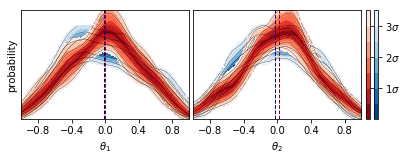

In [6]:
import nestcheck.plots
%matplotlib inline

fig = nestcheck.plots.bs_param_dists(run_list[:2])

Here the dashed dark red and dark blue lines mark the estimates of the mean of each parameter for the red and blue runs respectively. For a detailed explanation of this type of diagram and its uses, see ([Higson et al. 2018](https://arxiv.org/abs/1804.06406) Section 4.1 and Figure 3).

## Diagrams of samples in log X

The `param_logx_diagram` function plots nested sampling diagrams of the type proposed in ([Higson et al. 2018](https://arxiv.org/abs/1804.06406) Section 4.2 and shown in Figures 4 and 5).

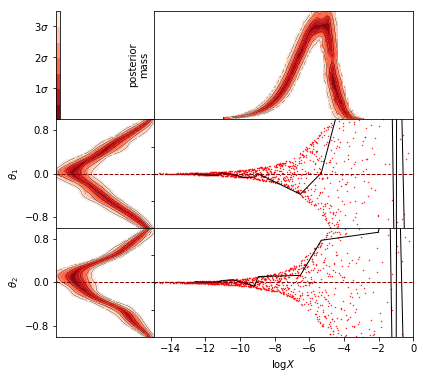

In [7]:
fig = nestcheck.plots.param_logx_diagram(run_list[0], logx_min=-15)


These diagrams illustrate the nested sampling algortithm's exponential compression of the prior by plotting samples in $\log X$, where $X(\mathcal{L}) \in [0, 1]$ is the fraction of the prior with likelihood greater than $\mathcal{L}$. The algorithm iterates towards higher likelihoods (towards lower $\log X$ values). The plots on the left are similar the distributions plotted in the previous cell, and the top right plot shows the relative posterior mass at each $\log X$ value. See [Higson et al. 2018](https://arxiv.org/abs/1804.06406) Section 4.2 for a detailed explanation and more examples.

## Calculating errors due to implementation-specific effects

Nested sampling software used for practical problems, such as MultiNest and PolyChord, uses numerical techniques to produce approximately uncorrelated samples within some iso-likelihood contour. However, for challenging problems - such as those with multimodal or degenerate posteriors - the software may fail to do this accurately, causing additional errors due to *implementation-specific effects* (see [Higson et al. 2018](https://arxiv.org/abs/1804.06406) for more details).

The error due to implementation-specific effects can be estimated with `nestcheck` using the method described in Section 5 of [Higson et al. 2018](https://arxiv.org/abs/1804.06406):

In [8]:
df = nestcheck.diagnostics_tables.run_list_error_summary(run_list, estimator_list, estimator_names, 100)
df

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='bs values', max=10), HTML(value='')))

$\mathrm{log} \mathcal{Z}$  \
calculation type        result type                               
values mean             value                         -5.918389   
                        uncertainty                    0.047744   
values std              value                          0.150980   
                        uncertainty                    0.035586   
bootstrap std mean      value                          0.217638   
                        uncertainty                    0.010354   
implementation std      value                          0.000000   
                        uncertainty                    0.055952   
implementation std frac value                          0.000000   
                        uncertainty                    6.940037   

                                     $\overline{\theta_{\hat{1}}}$  \
calculation type        result type                                  
values mean             value                            -0.002574   
                        uncertainty                       0.006330   
values std              value                             0.020019   
                        uncertainty                       0.004718   
bootstrap std mean      value                             0.026168   
                        uncertainty                       0.000704   
implementation std      value                             0.000000   
                        uncertainty                       0.009373   
implementation std frac value                             0.000000   
                        uncertainty                       2.363760   

                                     $\overline{\theta^2_{\hat{1}}}$  \
calculation type        result type                                    
values mean             value                               0.250480   
                        uncertainty                         0.005339   
values std              value                               0.016884   
                        uncertainty                         0.003980   
bootstrap std mean      value                               0.018131   
                        uncertainty                         0.000481   
implementation std      value                               0.000000   
                        uncertainty                         0.010334   
implementation std frac value                               0.000000   
                        uncertainty                         1.141478   

                                     $\overline{|\theta|}$  
calculation type        result type                         
values mean             value                     0.623917  
                        uncertainty               0.007926  
values std              value                     0.025065  
                        uncertainty               0.005908  
bootstrap std mean      value                     0.022129  
                        uncertainty               0.000441  
implementation std      value                     0.011771  
                        uncertainty               0.014222  
implementation std frac value                     0.469616  
                        uncertainty               1.763814

The 2-dimensional Gaussian likelihood is unimodal and easy for PolyChord to sample, so as expected we see that the standard deviation of the result values is close to the mean bootstrap standard deviation. Consequently the estimated errors due to implementation-specific effects are low.

## Tests for implementation specific effects using only 2 nested sampling runs

It is impossible to tell *a priori* if implementation-specific effects are present in a single nested sampling run without some additional knowledge of what the results should be. However diagnostic tests to determine if significant implementation-specific effects are present using only two nested sampling runs are proposed in [Higson et al. 2018](https://arxiv.org/abs/1804.06406).

1. The first test divides nested sampling runs into their constituent single live point runs ("threads") and assesses whether threads within each run are correlated with each other using the [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test). This yields a $p$-value, with $p \approx 0$ indicating implementation-specific effects are almost certainly present.
2. Secondly, the statistical distance between the uncertainty distributions (calculated from bootstrap replications) of quantities such as $\log X$ or parameter means for the two runs can be calculated. We use the Kolmogorov–Smirnov statistic as a distance measure; if this is close to 1 then there little or is no overlap between the distributions and additional errors from implementation-specific effects are likely present.

For a full explanation see the diagnostic tests paper ([Higson et al. 2018](https://arxiv.org/abs/1804.06406)).

These statistcs can be computed for pairs of runs using `nestcheck` as:

In [9]:
# perform error analysis on two runs
error_vals_df = nestcheck.diagnostics_tables.run_list_error_values(
    run_list[:2], estimator_list, estimator_names, thread_pvalue=True, bs_stat_dist=True, n_simulate=100)
# select only rows containing pairwise tests to output
error_vals_df.loc[pd.IndexSlice[['thread ks pvalue', 'bootstrap ks distance'], :], :]

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='bs values', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='thread values', max=2), HTML(value='')))

,,$\mathrm{log} \mathcal{Z}$,$\overline{\theta_{\hat{1}}}$,$\overline{\theta^2_{\hat{1}}}$,$\overline{|\theta|}$
calculation type,run,,,,
thread ks pvalue,"(1, 0)",0.343886,0.556017,0.67662,0.260553
bootstrap ks distance,"(1, 0)",0.190000,0.290000,0.58000,0.570000


As expected, the $p$-values are not particularly low nor are the KS distances particularly high - indicating there are significant implementation-specific effects for the simple 2-dimensional Gaussian.

If more than two runs are provided, the above function will calculate the diagnostics for each pairwise combination.